<a href="https://colab.research.google.com/github/babi00/ai4biological-pattern/blob/main/download_and_analyze_from_iNaturalist/annotate_unnotated_data_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modello che utilizza multi binary classes, BioCLIP come extractor embedding e semplice classificatore
(Download delle immagini in locale)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import requests
from io import BytesIO
from google.colab import drive
import time
import tqdm
!pip install open_clip_torch
import open_clip

torch.manual_seed(42)
np.random.seed(42)

!apt-get install git

# Clone the repository without checking out files
!git clone --filter=blob:none --no-checkout https://github.com/babi00/ai4biological-pattern.git
%cd ai4biological-pattern

# Enable sparse checkout
!git sparse-checkout init --cone



drive.mount('/content/drive')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
fatal: destination path 'ai4biological-pattern' already exists and is not an empty directory.
/content/ai4biological-pattern
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#1.Load and prepare data
class PlantPhenologyDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

        #possible phenology states
        self.phenology_classes = [
            'Flowering',
            'No Evidence of Flowering',
            'Flower Budding',
            'Fruiting'
        ]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
      row = self.dataframe.iloc[idx]
      obs_id = row['observation_id']

      #try to load images: they can have multiple formats
      variants = [f"{obs_id}_1.jpeg", f"{obs_id}_1.jpg", f"{obs_id}_1.JPG", f"{obs_id}_1.png", f"{obs_id}_1.PNG", f"{obs_id}_0.jpeg", f"{obs_id}_0.jpg", f"{obs_id}_0.JPG", f"{obs_id}_0.png", f"{obs_id}_0.PNG", f"{obs_id}_2.jpg", f"{obs_id}_2.jpeg"]

      image = None

      for filename in variants:
          local_path = os.path.join(self.img_dir, filename) #locally downloaded
          if os.path.exists(local_path):
              try:
                  image = Image.open(local_path).convert("RGB")
                  break
              except Exception as e:
                  print(f"Failed to open image {filename}: {e}")
              except:
                  continue

      if image is None:
          raise FileNotFoundError(f"Could not load any image for observation ID {obs_id}")

      if self.transform:
          image = self.transform(image)

      #one-hot encoded label vector for binary classifications
      label_vector = torch.zeros(len(self.phenology_classes))
      if pd.notna(row['value']):
          for i, phenology_class in enumerate(self.phenology_classes):
              #if this is the correct class, set to 1
              if row['value'] == phenology_class:
                  label_vector[i] = 1

      return image, label_vector, obs_id

#Data loading function for a single specie
def load_data_single_specie(csv_path, img_dir, use_bioclip=True, preprocess=None):
    df = pd.read_csv(csv_path)

    #Split into labeled and unlabeled data
    labeled_df = df[df['value'].notna()].copy()
    unlabeled_df = df[df['value'].isna()].copy()

    print(f"Total observations: {len(df)}")
    print(f"Labeled observations: {len(labeled_df)}")
    print(f"Unlabeled observations: {len(unlabeled_df)}")

    #Split labeled data into train and validation sets
    train_df, val_df = train_test_split(labeled_df, test_size=0.2, random_state=42, stratify=labeled_df['value'])

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")

    #Define transformations
    if use_bioclip and preprocess: #Use the same transform for train and val since BioCLIP has its own standardization
      train_transform = preprocess
      val_transform = preprocess
    else:
      train_transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.RandomHorizontalFlip(),
          transforms.RandomRotation(15),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

      val_transform = transforms.Compose([
          transforms.Resize((224, 224)),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ])

    #datasets
    train_dataset = PlantPhenologyDataset(train_df, img_dir, transform=train_transform)
    val_dataset = PlantPhenologyDataset(val_df, img_dir, transform=val_transform)
    unlabeled_dataset = PlantPhenologyDataset(unlabeled_df, img_dir, transform=val_transform)

    #dataloaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=16)

    return train_loader, val_loader, unlabeled_loader, train_dataset.phenology_classes

In [3]:
#2.Define the embedding extractor:
#ResNet without the last FC layer
def get_resnet_embeddings_extractor_model(num_classes):
    #Use a pre-trained ResNet18 model
    model = models.resnet18(weights='IMAGENET1K_V1')

    #Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    embeddings_extractor= nn.Sequential(*list(model.children())[:-1]) #removes the last FC layer

    return embeddings_extractor

#BioCLIP model
def get_bioclip_embeddings_extractor_model(device):
    model, _, preprocess = open_clip.create_model_and_transforms('hf-hub:imageomics/bioclip')
    model.to(device)
    model.eval()
    return model, preprocess

In [4]:
#3.Extract embeddings using the embeddings_extractor and create the DataLoader
def extract_embeddings(dataloader, embeddings_extractor, device, use_clip=True):
    embeddings_extractor.eval()
    all_embeddings = []
    all_labels = []
    all_ids = []

    if use_clip:
      with torch.no_grad():
        for images, labels, obs_id in dataloader:
            images = images.to(device)
            embeddings = embeddings_extractor.encode_image(images)
            embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)  # Optional: normalize
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)
            all_ids.extend(obs_id)

    else:
      with torch.no_grad():
        for images, labels, obs_id in dataloader:
            images = images.to(device)
            embeddings = embeddings_extractor(images).view(images.size(0), -1)
            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels)
            all_ids.extend(obs_id)

    embeddings_tensors = torch.cat(all_embeddings, dim=0).to(device)
    labels_tensors = torch.cat(all_labels, dim=0).to(device)
    obs_id_tensor = torch.tensor(all_ids).to(device)


    dataset = torch.utils.data.TensorDataset(embeddings_tensors, labels_tensors, obs_id_tensor)
    loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

    embedding_size = embeddings_tensors.shape[1] #useful for classifier

    return loader, embedding_size

In [5]:
#4.Construct a classifier that given the embedding it predicts the phenology state
class PhenologyClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim=512, num_classes=4):
        super().__init__()
        self.classifier = nn.Sequential(
              nn.Linear(input_dim, hidden_dim),
              nn.ReLU(),
              nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.classifier(x)

In [6]:
#5. Training function
def train_classifier(classifier, train_loader, val_loader, criterion, optimizer, device, folder_name, phenology_classes, model_name, num_epochs=10, lr=0.001):
    classifier.to(device)
    best_val_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc_per_class': [], 'val_acc_per_class': [], 'train_acc': [],'val_acc': []}
    num_classes = len(phenology_classes)

    for epoch in range(num_epochs):
        classifier.train()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        for embeddings, labels, _ in train_loader:
            #zero the parameter gradients
            optimizer.zero_grad()

            #forward pass
            outputs = classifier(embeddings)
            loss = criterion(outputs, labels.float())

            #backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * embeddings.size(0)

            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1
            correct += (preds == labels).sum(dim=0)
            total += labels.size(0)


        #track statistics to draw graph
        epoch_train_loss = running_loss / total.sum().item()
        epoch_train_acc_per_class = (correct / total).cpu().numpy()
        epoch_train_acc = correct.sum().item() / total.sum().item()
        epoch_val_acc = correct.sum().item() / total.sum().item()
        history['train_loss'].append(epoch_train_loss)
        history['train_acc_per_class'].append(epoch_train_acc_per_class)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        #validation phase
        classifier.eval()
        running_loss = 0.0
        correct = torch.zeros(num_classes).to(device)
        total = torch.zeros(num_classes).to(device)

        with torch.no_grad():
            for embeddings, labels, _ in val_loader:
                outputs = classifier(embeddings)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * embeddings.size(0)

                probs = torch.sigmoid(outputs)
                preds = torch.zeros_like(probs)
                top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
                preds[range(probs.size(0)), top_class] = 1
                correct += (preds == labels).sum(dim=0)
                total += labels.size(0)

        #track statistics to draw graph
        epoch_val_loss = running_loss / total.sum().item()
        epoch_val_acc_per_class = (correct / total).cpu().numpy()
        history['val_loss'].append(epoch_val_loss)
        history['val_acc_per_class'].append(epoch_val_acc_per_class)

        print(f'Epoch {epoch+1}/{num_epochs}: '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Validation Loss: {epoch_val_loss:.4f}')

    torch.save(classifier.state_dict(), f'{folder_name}.pth')
    google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/phenology_models/{model_name}{folder_name}.pth'
    torch.save(classifier.state_dict(), google_drive_path)
    classifier.load_state_dict(torch.load(f'{folder_name}.pth'))
    return classifier, history

In [7]:
#6. Evaluate the model
def evaluate_classifier(classifier, dataloader, device, phenology_classes, folder_name, model_name):
    classifier.eval()
    all_preds = []
    all_labels = []
    all_ids = []

    with torch.no_grad():
        for embeddings, labels, obs_ids in dataloader:
            outputs = classifier(embeddings)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
            all_ids.extend(obs_ids.cpu())



    #confusion matrix
    all_preds = torch.cat(all_preds, dim=0).cpu().numpy().astype(int)
    all_labels = torch.cat(all_labels, dim=0).cpu().numpy().astype(int)

    print(classification_report(all_labels, all_preds, target_names=phenology_classes))

    cm = multilabel_confusion_matrix(all_labels, all_preds)
    class_names = phenology_classes

    n_classes = len(class_names)
    cols = 2
    rows = (n_classes + 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
    axes = axes.flatten()

    for i in range(n_classes):
        ax = axes[i]
        cmat = cm[i]
        im = ax.imshow(cmat, interpolation='nearest', cmap=plt.cm.Blues)
        ax.set_title(f'"{class_names[i]}"')
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['Not Present', 'Present'])
        ax.set_yticklabels(['Not Present', 'Present'])
        ax.set_ylabel('True')
        ax.set_xlabel('Predicted')

        thresh = cmat.max() / 2
        for j in range(2):
            for k in range(2):
                ax.text(k, j, format(cmat[j, k], 'd'),
                        ha="center", va="center",
                        color="white" if cmat[j, k] > thresh else "black")

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f'{model_name}all_confusion_matrices_{folder_name}.png')
    plt.show()


    #Create a DataFrame with results
    results_df = pd.DataFrame({
        'observation_id': all_ids,
        'true_phenology': [phenology_classes[i] for i in np.argmax(all_labels, axis=1)],
        'predicted_phenology': [phenology_classes[i] for i in np.argmax(all_preds, axis=1)]
    })

    return results_df

In [8]:
#7. Make predictions on unlabeled data
def predict_unlabeled(classifier, dataloader, device, phenology_classes):
    classifier.eval()
    all_preds = []
    all_ids = []

    with torch.no_grad():
        for embeddings, labels, obs_ids in dataloader:
            outputs = classifier(embeddings)
            probs = torch.sigmoid(outputs)
            preds = torch.zeros_like(probs)
            top_class = torch.argmax(probs, dim=1) #only the class with the highest probability is marked 1
            preds[range(probs.size(0)), top_class] = 1

            all_preds.extend(preds.cpu())
            all_ids.extend(obs_ids.cpu())

    #Create a DataFrame with predictions
    predictions_df = pd.DataFrame({
        'observation_id': all_ids,
        'predicted_phenology': [phenology_classes[np.argmax(pred)] for pred in all_preds]
    })

    return predictions_df

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/599M [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/469 [00:00<?, ?B/s]

Total observations: 10487
Labeled observations: 781
Unlabeled observations: 9706
Training set size: 624
Validation set size: 157
Epoch 1/15: Train Loss: 0.1427, Validation Loss: 0.1149
Epoch 2/15: Train Loss: 0.0969, Validation Loss: 0.0877
Epoch 3/15: Train Loss: 0.0771, Validation Loss: 0.0735
Epoch 4/15: Train Loss: 0.0662, Validation Loss: 0.0657
Epoch 5/15: Train Loss: 0.0592, Validation Loss: 0.0619
Epoch 6/15: Train Loss: 0.0546, Validation Loss: 0.0596
Epoch 7/15: Train Loss: 0.0520, Validation Loss: 0.0580
Epoch 8/15: Train Loss: 0.0489, Validation Loss: 0.0580
Epoch 9/15: Train Loss: 0.0468, Validation Loss: 0.0572
Epoch 10/15: Train Loss: 0.0446, Validation Loss: 0.0576
Epoch 11/15: Train Loss: 0.0430, Validation Loss: 0.0576
Epoch 12/15: Train Loss: 0.0422, Validation Loss: 0.0596
Epoch 13/15: Train Loss: 0.0399, Validation Loss: 0.0581
Epoch 14/15: Train Loss: 0.0384, Validation Loss: 0.0586
Epoch 15/15: Train Loss: 0.0373, Validation Loss: 0.0595


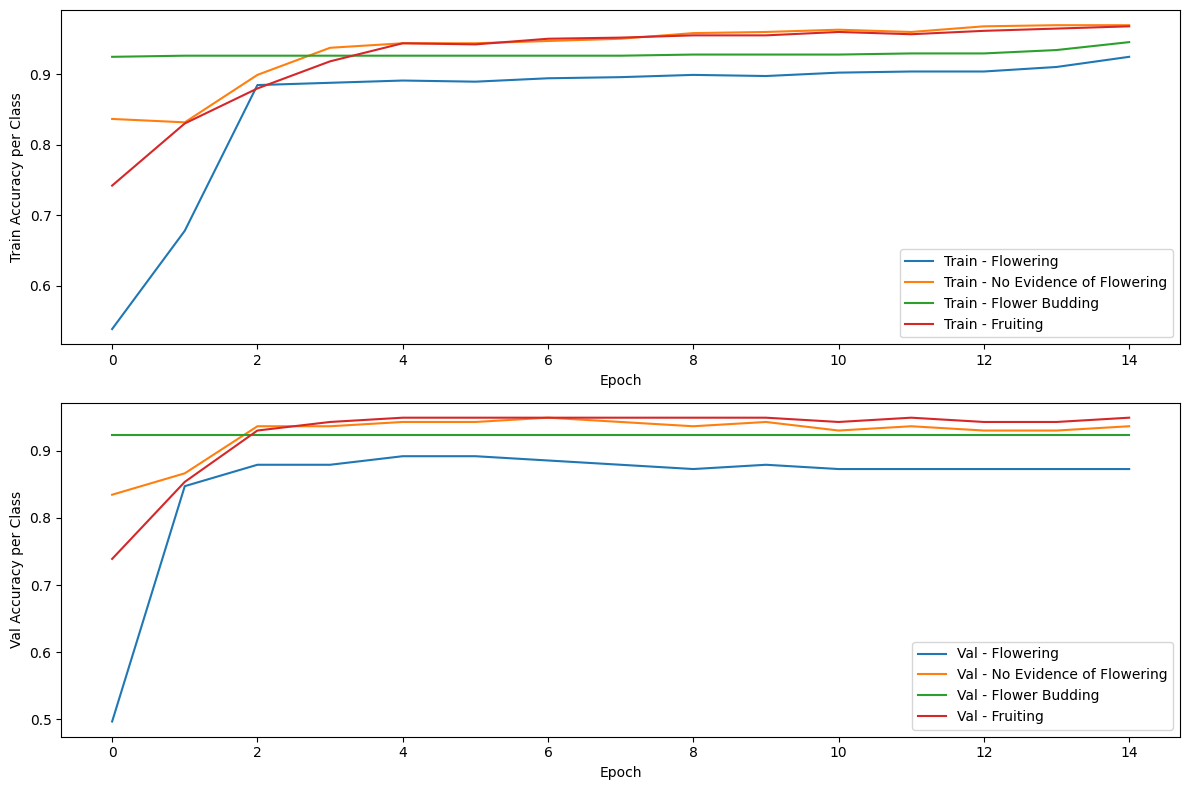

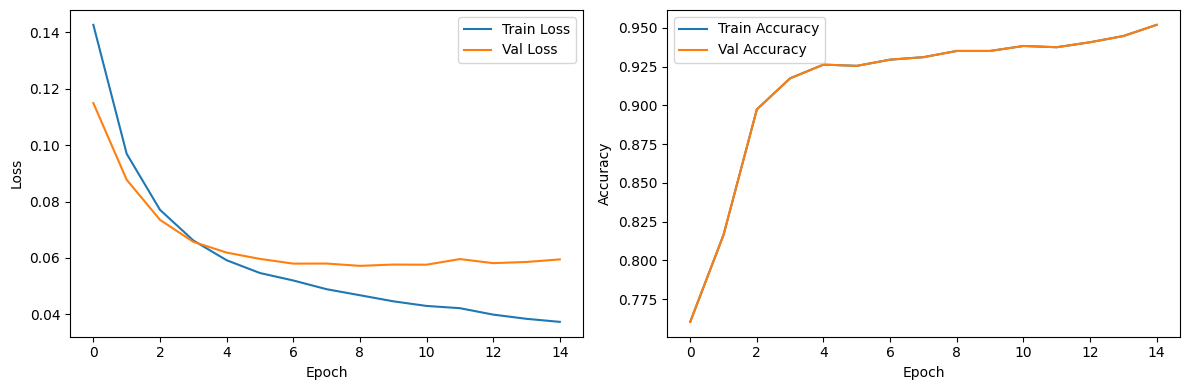

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

               Flowering       0.82      0.96      0.88        78
No Evidence of Flowering       0.77      0.88      0.82        26
          Flower Budding       0.00      0.00      0.00        12
                Fruiting       0.97      0.83      0.89        41

               micro avg       0.84      0.84      0.84       157
               macro avg       0.64      0.67      0.65       157
            weighted avg       0.79      0.84      0.81       157
             samples avg       0.84      0.84      0.84       157



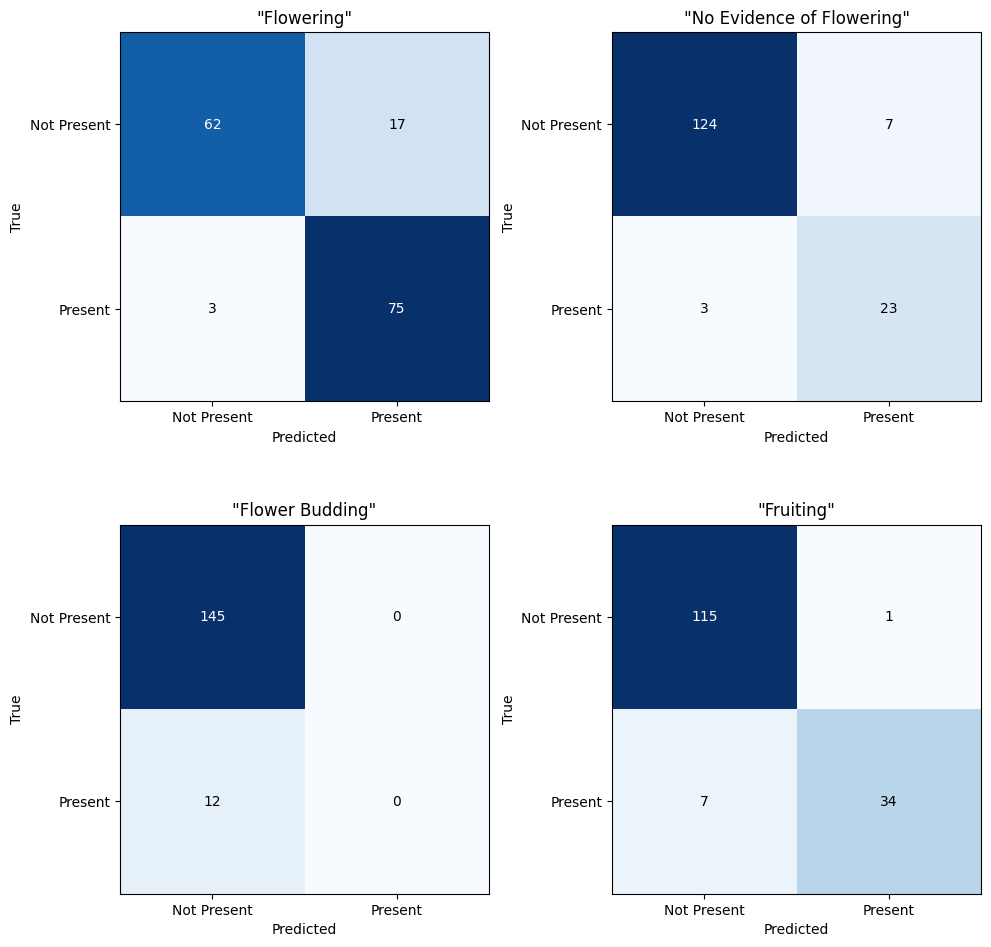

Successfully updated phenology data!


In [ ]:
folder_name='PROVA_fragola_verde'
#to download from github
#github_repository = 'https://raw.githubusercontent.com/babi00/ai4biological-pattern/download_and_analyze_iNaturalist/download_and_analyze_from_iNaturalist/PROVA_fragola_verde/'
#to retrieve from locally downloaded repository
github = '/content/ai4biological-pattern/download_and_analyze_from_iNaturalist'
github_repository = f'{github}/{folder_name}/'
csv_path = f'{github_repository}annotations_detailed_{folder_name}.csv'
img_dir = f'{github_repository}inat_photos/'

if not os.path.isdir(github_repository): #check if data has already been downloaded
    !git sparse-checkout set download_and_analyze_from_iNaturalist/{folder_name}
    !git checkout main

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#embedding extractor model
embeddings_extractor, preprocess = get_bioclip_embeddings_extractor_model(device)
embeddings_extractor = embeddings_extractor.to(device)

#Load data
train_loader, val_loader, unlabeled_loader, phenology_classes = load_data_single_specie(csv_path, img_dir, preprocess)


#extract embeddings and save in dataloaders
embeddings_train_loader, input_size = extract_embeddings(train_loader, embeddings_extractor, device)
embeddings_val_loader, _ = extract_embeddings(val_loader, embeddings_extractor, device)
embeddings_unlabeled_loader, _ = extract_embeddings(unlabeled_loader, embeddings_extractor, device)

#initialize classifier
classifier = PhenologyClassifier(input_size)

#Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss() #for multiple binary classification
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=0.001) #make sure than the optimizer does not modify all layers: only those earlier specified (not freezed)

#Train model
classifier, history = train_classifier(classifier, embeddings_train_loader, embeddings_val_loader, criterion, optimizer, device, folder_name, phenology_classes, model_name, num_epochs=15)

# Plot training history for accuracy per class
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
for i in range(len(phenology_classes)):
    acc = [epoch[i] for epoch in history['train_acc_per_class']]
    plt.plot(acc, label=f'Train - {phenology_classes[i]}')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy per Class')
plt.legend()

plt.subplot(2, 1, 2)
for i in range(len(phenology_classes)):
    acc = [epoch[i] for epoch in history['val_acc_per_class']]
    plt.plot(acc, label=f'Val - {phenology_classes[i]}')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy per Class')
plt.legend()

plt.tight_layout()
plt.savefig(f'bioclip_training_accuracy_per_class_{folder_name}.png')
plt.show()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig(f'bioclip_training_history_{folder_name}.png')
plt.show()

#Evaluate model on validation set
results_df = evaluate_classifier(classifier, embeddings_val_loader, device, phenology_classes, folder_name, model_name)
results_df.to_csv(f'bioclip_validation_results_{folder_name}.csv', index=False)

#Make predictions on unlabeled data
predictions_df = predict_unlabeled(classifier, embeddings_unlabeled_loader, device, phenology_classes)
predictions_df.to_csv(f'bioclip_unlabeled_predictions_{folder_name}.csv', index=False)

#Merge predictions with original CSV
original_df = pd.read_csv(csv_path)

#Only update rows where Plant Phenology value is missing
mask = (original_df['term'] == 'Plant Phenology') & (original_df['value'].isna())

#Create a dictionary mapping observation_id to predicted phenology
pred_dict = dict(zip(predictions_df['observation_id'], predictions_df['predicted_phenology']))

#Update and save original DataFrame
original_df.loc[mask, 'value'] = original_df.loc[mask, 'observation_id'].map(pred_dict)

original_df.to_csv(f'bioclip_updated_data_{folder_name}.csv', index=False)
google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/bioclip_updated_data_{folder_name}.csv'
original_df.to_csv(google_drive_path, index=False)

print("Successfully updated phenology data!")

In [9]:
def create_model_and_predict(folder_name, use_bioclip=True):

    start_time = time.time()

    #to download from github
    #github_repository = 'https://raw.githubusercontent.com/babi00/ai4biological-pattern/download_and_analyze_iNaturalist/download_and_analyze_from_iNaturalist/PROVA_fragola_verde/'
    #to retrieve from locally downloaded repository
    github = '/content/ai4biological-pattern/download_and_analyze_from_iNaturalist'
    github_repository = f'{github}/{folder_name}/'
    csv_path = f'{github_repository}annotations_detailed_{folder_name}.csv'
    img_dir = f'{github_repository}inat_photos/'

    if not os.path.isdir(github_repository): #check if data has already been downloaded
        !git sparse-checkout set download_and_analyze_from_iNaturalist/{folder_name}
        !git checkout main

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    #embedding extractor model
    if use_bioclip:
        embeddings_extractor, preprocess = get_bioclip_embeddings_extractor_model(device)
        embeddings_extractor = embeddings_extractor.to(device)
    else:
        embeddings_extractor = get_resnet_embeddings_extractor_model()
        embeddings_extractor = embeddings_extractor.to(device)
        preprocess = None

    #Load data
    train_loader, val_loader, unlabeled_loader, phenology_classes = load_data_single_specie(csv_path, img_dir, use_bioclip=use_bioclip, preprocess=preprocess)


    #extract embeddings and save in dataloaders
    embeddings_train_loader, input_size = extract_embeddings(train_loader, embeddings_extractor, device)
    embeddings_val_loader, _ = extract_embeddings(val_loader, embeddings_extractor, device)
    embeddings_unlabeled_loader, _ = extract_embeddings(unlabeled_loader, embeddings_extractor, device)

    #initialize classifier
    classifier = PhenologyClassifier(input_size)

    #Define loss function and optimizer
    criterion = nn.BCEWithLogitsLoss() #for multiple binary classification
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=0.001) #make sure than the optimizer does not modify all layers: only those earlier specified (not freezed)

    #to save model and figures
    model_name = "bioclip_" if use_bioclip else "resnet_"
    #Train model
    classifier, history = train_classifier(classifier, embeddings_train_loader, embeddings_val_loader, criterion, optimizer, device, folder_name, phenology_classes, model_name, num_epochs=15)

    # Plot training history for accuracy per class
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    for i in range(len(phenology_classes)):
        acc = [epoch[i] for epoch in history['train_acc_per_class']]
        plt.plot(acc, label=f'Train - {phenology_classes[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('Train Accuracy per Class')
    plt.legend()

    plt.subplot(2, 1, 2)
    for i in range(len(phenology_classes)):
        acc = [epoch[i] for epoch in history['val_acc_per_class']]
        plt.plot(acc, label=f'Val - {phenology_classes[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('Val Accuracy per Class')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}training_accuracy_per_class_{folder_name}.png')
    plt.show()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}training_history_{folder_name}.png')
    plt.show()

    #Evaluate model on validation set
    results_df = evaluate_classifier(classifier, embeddings_val_loader, device, phenology_classes, folder_name, model_name)
    results_df.to_csv(f'{model_name}validation_results_{folder_name}.csv', index=False)

    #Make predictions on unlabeled data
    predictions_df = predict_unlabeled(classifier, embeddings_unlabeled_loader, device, phenology_classes)
    predictions_df.to_csv(f'{model_name}unlabeled_predictions_{folder_name}.csv', index=False)

    #Merge predictions with original CSV
    original_df = pd.read_csv(csv_path)

    #Only update rows where Plant Phenology value is missing
    mask = (original_df['term'] == 'Plant Phenology') & (original_df['value'].isna())

    #Create a dictionary mapping observation_id to predicted phenology
    pred_dict = dict(zip(predictions_df['observation_id'], predictions_df['predicted_phenology']))

    #Update and save original DataFrame
    original_df.loc[mask, 'value'] = original_df.loc[mask, 'observation_id'].map(pred_dict)

    original_df.to_csv(f'{model_name}updated_data_{folder_name}.csv', index=False)
    google_drive_path = f'/content/drive/MyDrive/TESI - PoliTO/{model_name}updated_data_{folder_name}.csv'
    original_df.to_csv(google_drive_path, index=False)

    print("Successfully updated phenology data!")

Using device: cuda
Total observations: 10487
Labeled observations: 781
Unlabeled observations: 9706
Training set size: 624
Validation set size: 157
Epoch 1/15: Train Loss: 0.1456, Validation Loss: 0.1150
Epoch 2/15: Train Loss: 0.1024, Validation Loss: 0.0905
Epoch 3/15: Train Loss: 0.0810, Validation Loss: 0.0747
Epoch 4/15: Train Loss: 0.0687, Validation Loss: 0.0666
Epoch 5/15: Train Loss: 0.0602, Validation Loss: 0.0623
Epoch 6/15: Train Loss: 0.0554, Validation Loss: 0.0604
Epoch 7/15: Train Loss: 0.0518, Validation Loss: 0.0593
Epoch 8/15: Train Loss: 0.0493, Validation Loss: 0.0587
Epoch 9/15: Train Loss: 0.0468, Validation Loss: 0.0586
Epoch 10/15: Train Loss: 0.0450, Validation Loss: 0.0590
Epoch 11/15: Train Loss: 0.0431, Validation Loss: 0.0586
Epoch 12/15: Train Loss: 0.0422, Validation Loss: 0.0597
Epoch 13/15: Train Loss: 0.0401, Validation Loss: 0.0596
Epoch 14/15: Train Loss: 0.0387, Validation Loss: 0.0605
Epoch 15/15: Train Loss: 0.0374, Validation Loss: 0.0594


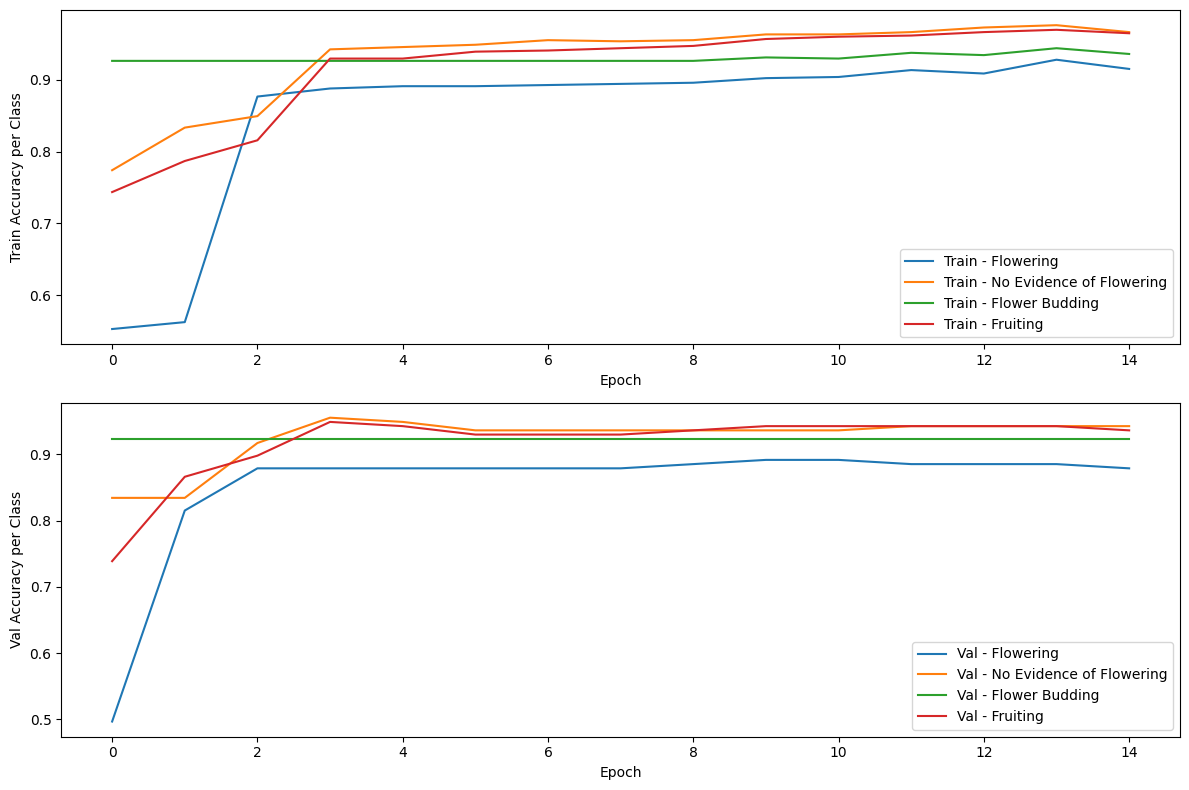

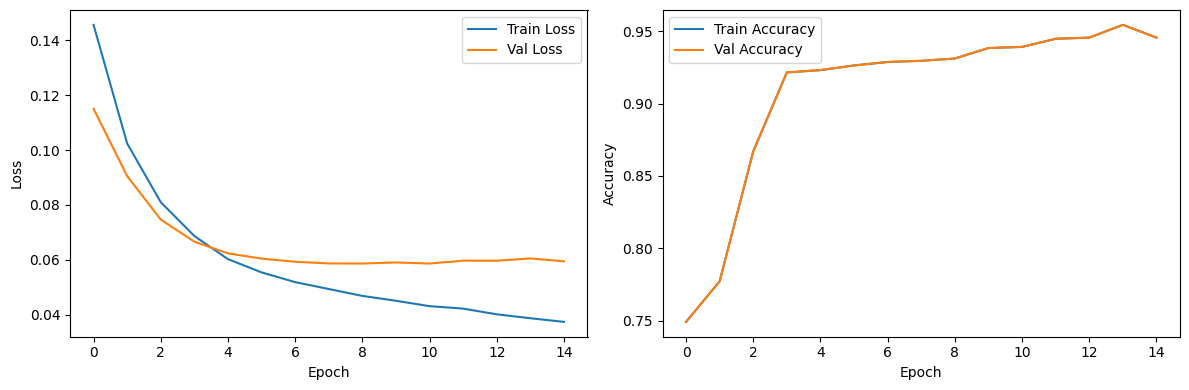

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                          precision    recall  f1-score   support

               Flowering       0.83      0.95      0.89        78
No Evidence of Flowering       0.76      0.96      0.85        26
          Flower Budding       0.00      0.00      0.00        12
                Fruiting       0.94      0.80      0.87        41

               micro avg       0.84      0.84      0.84       157
               macro avg       0.63      0.68      0.65       157
            weighted avg       0.78      0.84      0.81       157
             samples avg       0.84      0.84      0.84       157



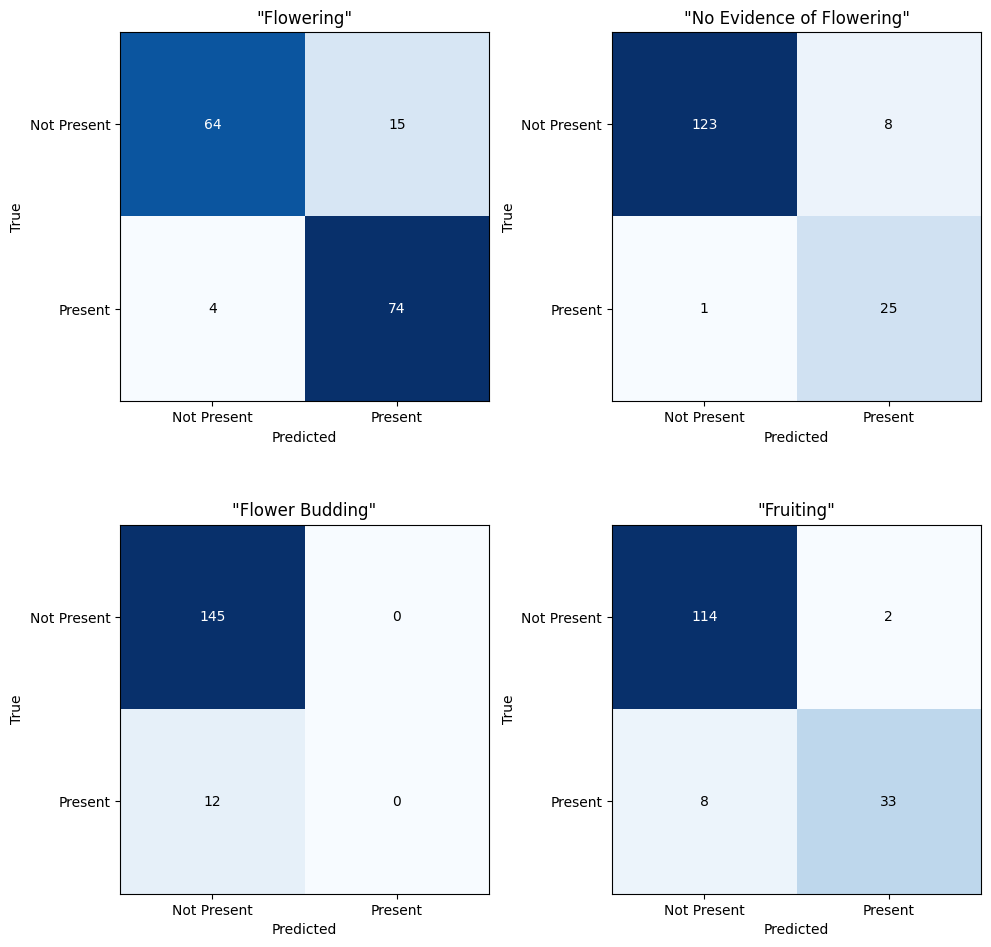

Successfully updated phenology data!


In [ ]:
create_model_and_predict('PROVA_fragola_verde')

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total observations: 22397
Labeled observations: 8246
Unlabeled observations: 14151
Training set size: 6596
Validation set size: 1650
Epoch 1/15: Train Loss: 0.0778, Validation Loss: 0.0486
Epoch 2/15: Train Loss: 0.0500, Validation Loss: 0.0444
Epoch 3/15: Train Loss: 0.0462, Validation Loss: 0.0422
Epoch 4/15: Train Loss: 0.0440, Validation Loss: 0.0407
Epoch 5/15: Train Loss: 0.0422, Validation Loss: 0.0402
Epoch 6/15: Train Loss: 0.0407, Validation Loss: 0.0403
Epoch 7/15: Train Loss: 0.0397, Validation Loss: 0.0401
Epoch 8/15: Train Loss: 0.0384, Validation Loss: 0.0400
Epoch 9/15: Train Loss: 0.0371, Validation Loss: 0.0404
Epoch 10/15: Train Loss: 0.0359, Validation Loss: 0.0407
Epoch 11/15: Train Loss: 0.0348, Validation Loss: 0.0404
Epoch 12/15: Train Loss: 0.0338, Validation Loss: 0.0411
Epoch 13/15: Train Loss: 0.0327, Validation Loss: 0.0414
Epoch 14/15: Train Loss: 0.0318, Validation Loss: 0.0419
Epoch 15/15: Train Loss: 0.0306, Validation Loss: 0.0425


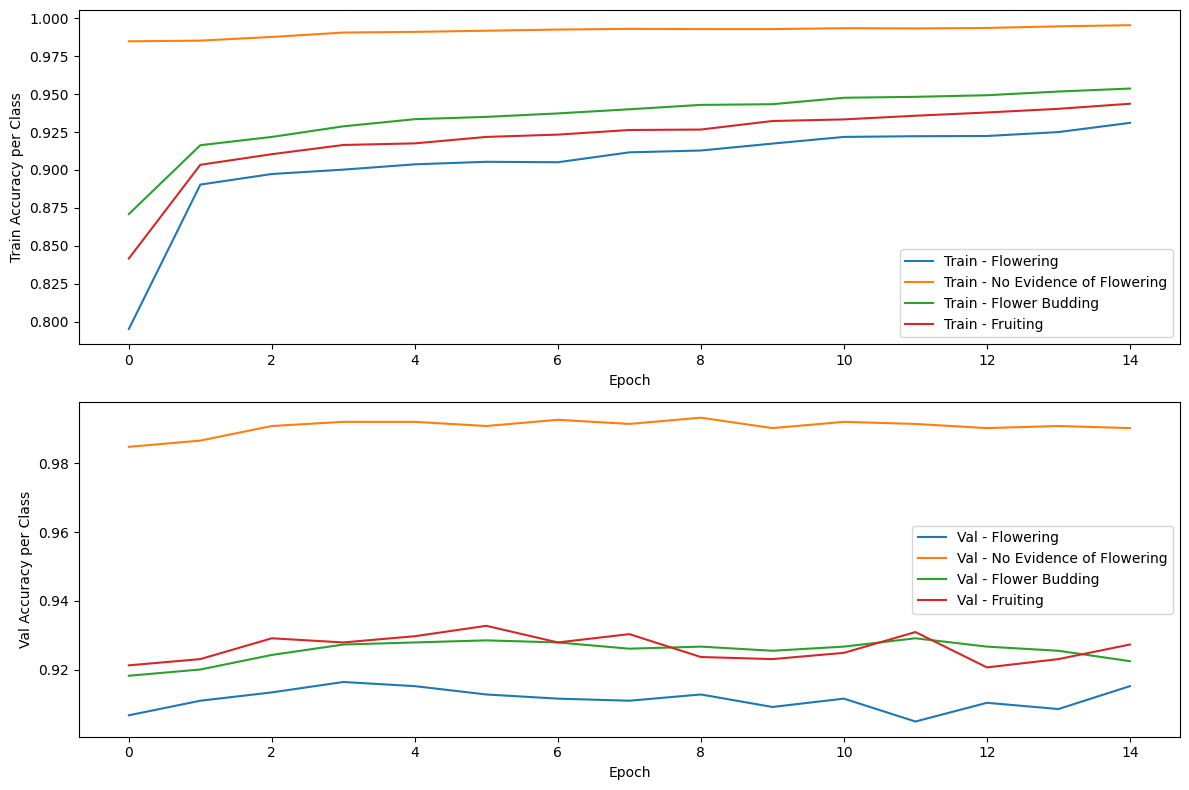

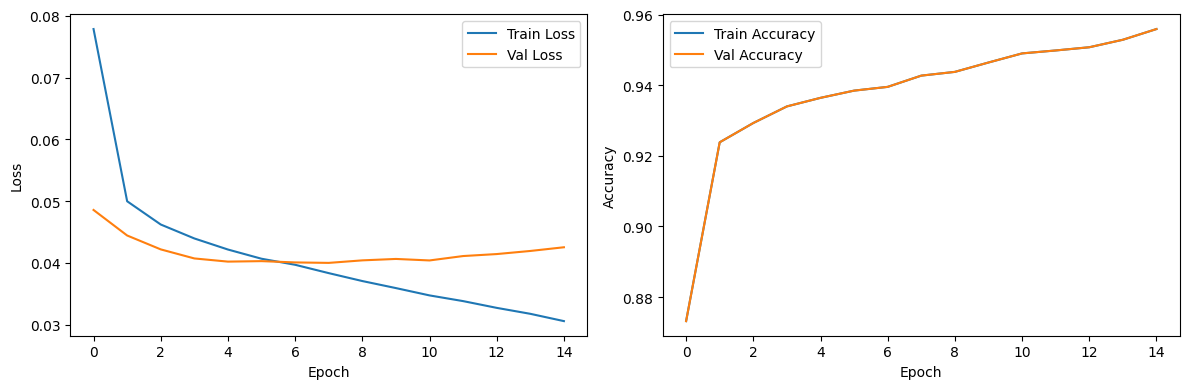

                          precision    recall  f1-score   support

               Flowering       0.91      0.88      0.90       680
No Evidence of Flowering       0.74      0.56      0.64        25
          Flower Budding       0.77      0.90      0.83       349
                Fruiting       0.92      0.87      0.90       596

               micro avg       0.88      0.88      0.88      1650
               macro avg       0.83      0.80      0.81      1650
            weighted avg       0.88      0.88      0.88      1650
             samples avg       0.88      0.88      0.88      1650



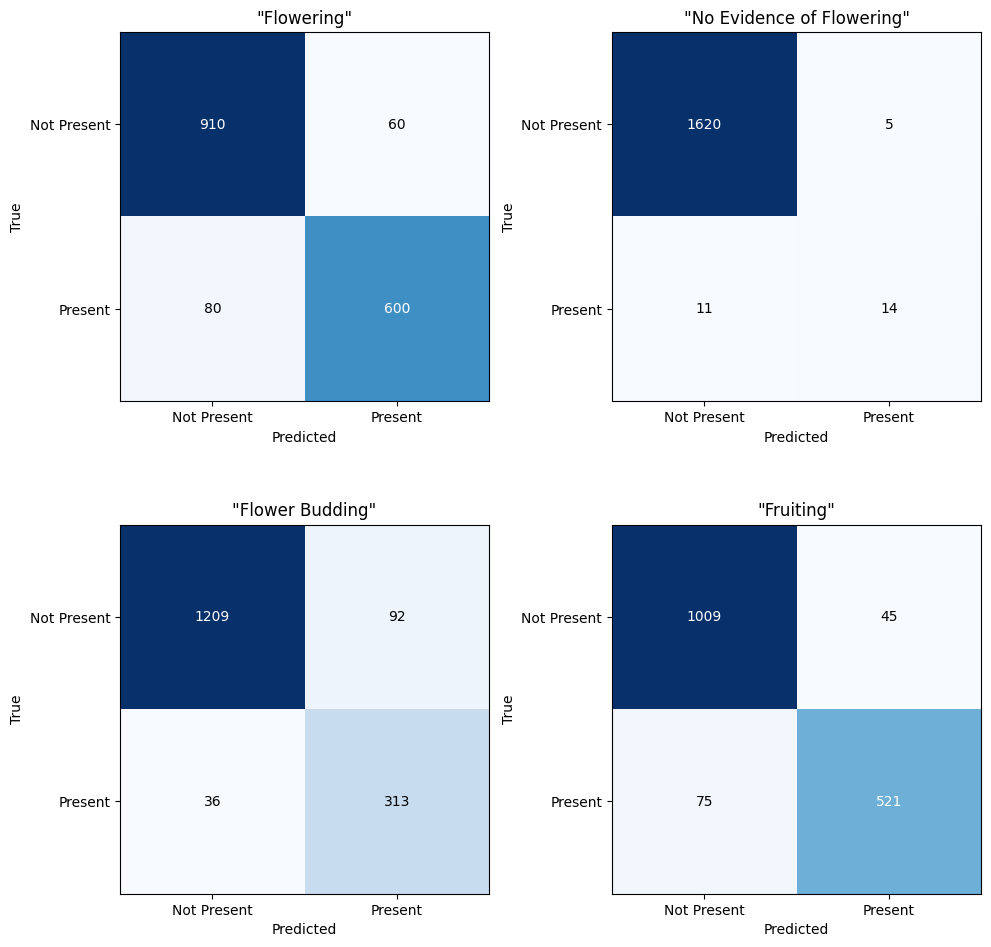

Successfully updated phenology data!


In [ ]:
create_model_and_predict('complete_dactylis_glomerata_n_a')

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Total observations: 79498
Labeled observations: 9257
Unlabeled observations: 70241
Training set size: 7405
Validation set size: 1852
Epoch 1/15: Train Loss: 0.0454, Validation Loss: 0.0346
Epoch 2/15: Train Loss: 0.0321, Validation Loss: 0.0335
Epoch 3/15: Train Loss: 0.0304, Validation Loss: 0.0325
Epoch 4/15: Train Loss: 0.0292, Validation Loss: 0.0328
Epoch 5/15: Train Loss: 0.0286, Validation Loss: 0.0322
Epoch 6/15: Train Loss: 0.0277, Validation Loss: 0.0323
Epoch 7/15: Train Loss: 0.0272, Validation Loss: 0.0329
Epoch 8/15: Train Loss: 0.0268, Validation Loss: 0.0324
Epoch 9/15: Train Loss: 0.0262, Validation Loss: 0.0327
Epoch 10/15: Train Loss: 0.0257, Validation Loss: 0.0324
Epoch 11/15: Train Loss: 0.0253, Validation Loss: 0.0330
Epoch 12/15: Train Loss: 0.0249, Validation Loss: 0.0328
Epoch 13/15: Train Loss: 0.0244, Validation Loss: 0.0328
Epoch 14/15: Train Loss: 0.0240, Validation Loss: 0.0331
Epoch 15/15: Train Loss: 0.0233, Validation Loss: 0.0337


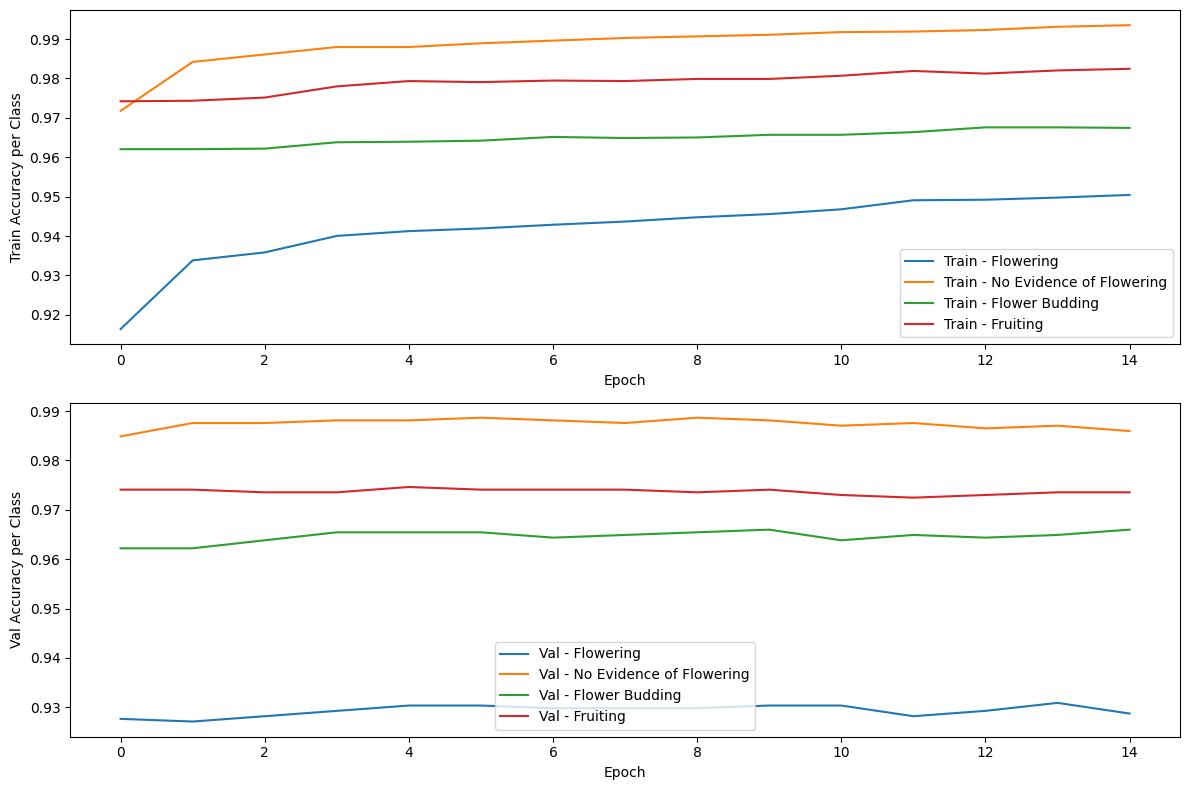

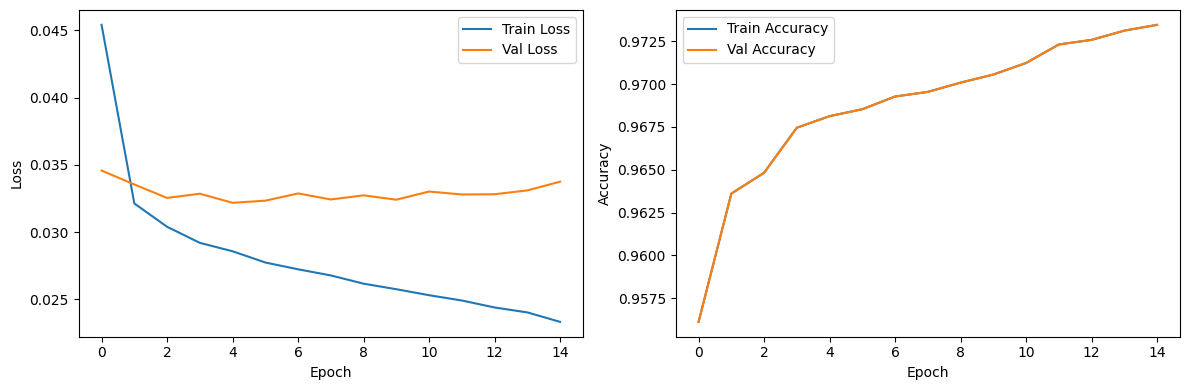

                          precision    recall  f1-score   support

               Flowering       0.94      0.99      0.96      1619
No Evidence of Flowering       0.89      0.89      0.89       115
          Flower Budding       0.73      0.16      0.26        70
                Fruiting       0.46      0.12      0.20        48

               micro avg       0.93      0.93      0.93      1852
               macro avg       0.75      0.54      0.58      1852
            weighted avg       0.91      0.93      0.91      1852
             samples avg       0.93      0.93      0.93      1852



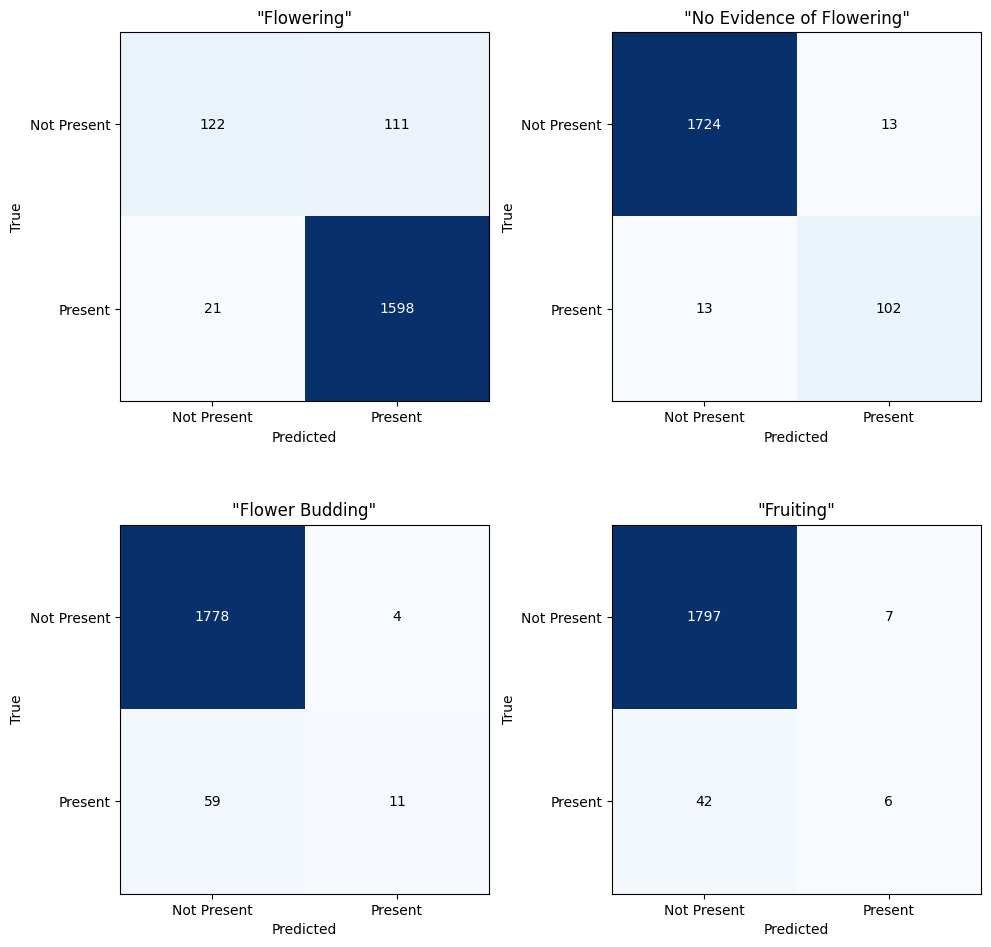

Successfully updated phenology data!


In [10]:
create_model_and_predict('complete_trifolium_pratense_n_a')